This notebook walks through a few examples that show how to use `triceratops`. The examples below show:

1. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it TESS}$ sector $\textbf{without}$ follow up data.
2. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it TESS}$ sector $\textbf{with}$ follow up data.
3. How to apply `triceratops` on a star observed in $\textbf{multiple}$ ${\it TESS}$ sectors $\textbf{without}$ follow up data.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

import triceratops.triceratops as tr

## Example #1

First, let's apply the tool on TOI 465.01 (aka TIC 270380593.01, aka WASP-156b), which was observed with a 2 minute cadence in sector 4.

Begin by defining the target star object with the `target(ID, sectors)` class. The arguments for this class are `ID` (the TIC ID of the star) and `sectors` (the sectors in which the star was observed). `ID` should be an integer and `sectors` should be a numpy array.



In [2]:
ID = 270380593
sectors = np.array([4])
target = tr.target(ID=ID, sectors=sectors)

Next, let's define the aperture used to extract the light curve, plot an image of the field, and display a table of nearby stars.

The aperture should be a 2D numpy array with the formal `[[col#, row#], [col#, row#], [col#, row#], ...]`, where where each `[col#, row#]` is the column and row number of the pixel.

An image of the field can be plotted with the `.plot_field(sector, ap_pixels)` method. This method takes as optional arguments `sector` (the image sector you would like to plot) and `ap_pixels` (the aperture we just defined).

We can display a table of the stars in the image with the `.stars` attribute.

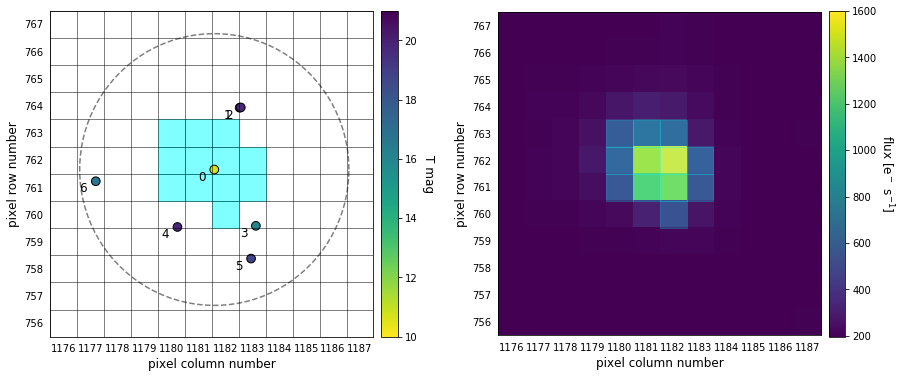

,ID,Tmag,ra,dec,mass,rad,Teff,logg,lum,plx,Vmag,Kmag
0,270380593,10.7307,32.781765,2.418021,0.811000,0.847380,4936.0,4.49093,0.384018,8.163660,11.5590,9.339
1,270380591,20.0711,32.780541,2.404015,NaN,NaN,NaN,NaN,NaN,NaN,20.9809,15.772
2,514519134,19.7713,32.780333,2.403886,NaN,NaN,NaN,NaN,NaN,NaN,21.8003,NaN
3,270380594,16.0568,32.770020,2.426293,0.513011,0.515342,3516.0,4.72400,0.036566,2.251200,18.2272,13.765
4,630359580,19.8256,32.785538,2.431950,NaN,NaN,NaN,NaN,NaN,-0.477026,21.3746,NaN
5,630359579,18.7953,32.768955,2.433112,NaN,NaN,NaN,NaN,NaN,0.087234,20.3556,NaN
6,270380595,16.7050,32.804587,2.428540,0.640000,0.795370,4073.0,4.44311,0.156852,0.839486,18.0776,14.588


In [3]:
ap = np.array([ [1180, 763], [1181, 763], [1182, 763], 
                [1180, 762], [1181, 762], [1182, 762], [1183, 762], 
                [1180, 761], [1181, 761], [1182, 761], [1183, 761], 
                                          [1182, 760]])

target.plot_field(sector=4, ap_pixels=ap)
 
target.stars

We can now determine which stars in the aperture are bright enough to produce the observed transit. The transit for this TOI has a depth of ~5000 ppm. We'll use the `.calc_depths(tdepth, all_ap_pixels)` method to do this. This method takes as arguments `tdepth` (the transit depth of the candidate) and `all_ap_pixels` (a numpy array of all apertures). After doing this, the `.stars` table includes the flux ratio contributed by each star in the aperture and the transit depth each star would have if it were the host of the signal.

In [4]:
apertures = np.array([ap])
target.calc_depths(tdepth=0.005, all_ap_pixels=apertures)

target.stars

,ID,Tmag,ra,dec,mass,rad,Teff,logg,lum,plx,Vmag,Kmag,fluxratio,tdepth
0,270380593,10.7307,32.781765,2.418021,0.811000,0.847380,4936.0,4.49093,0.384018,8.163660,11.5590,9.339,1.0,0.005
1,270380591,20.0711,32.780541,2.404015,NaN,NaN,NaN,NaN,NaN,NaN,20.9809,15.772,0.0,0.000
2,514519134,19.7713,32.780333,2.403886,NaN,NaN,NaN,NaN,NaN,NaN,21.8003,NaN,0.0,0.000
3,270380594,16.0568,32.770020,2.426293,0.513011,0.515342,3516.0,4.72400,0.036566,2.251200,18.2272,13.765,0.0,0.000
4,630359580,19.8256,32.785538,2.431950,NaN,NaN,NaN,NaN,NaN,-0.477026,21.3746,NaN,0.0,0.000
5,630359579,18.7953,32.768955,2.433112,NaN,NaN,NaN,NaN,NaN,0.087234,20.3556,NaN,0.0,0.000
6,270380595,16.7050,32.804587,2.428540,0.640000,0.795370,4073.0,4.44311,0.156852,0.839486,18.0776,14.588,0.0,0.000


After doing this, we can calculate the probability of each scenario using the `.calc_prob(time, flux_0, flux_err_0, P_orb)` method, which requires as arguments `time` (times from phase-folded light curve in units of days from transit center), `flux_0` (normalized flux from phase-folded light curve), `flux_err_0` (flux error values of the target's phase-folded light curve), and `P_orb` (orbital period of the TOI in days).

This should only take a few minutes. There may be a few warnings printed during this process, but they don't affect the calculation (I'm working these out).

In [5]:
%%time

lc = pd.read_csv("TOI465_01_lightcurve.csv", header=None)
time, flux, flux_err = lc[0].values, lc[1].values, lc[2].values
P_orb = 3.836169

target.calc_probs(time=time, flux_0=flux, flux_err_0=flux_err, P_orb=P_orb)

TRILEGAL form submitted.
Calculating TTP and TEB scenario probabilities for 270380593.
Calculating PTP, PEB, STP, and SEB scenario probabilities for 270380593.
Calculating DTP, DEB, BTP, and BEB scenario probabilities for 270380593.
CPU times: user 3min 28s, sys: 82.7 ms, total: 3min 28s
Wall time: 3min 52s


Now that that's done, let's check out a table of our results with the `.probs` attribute and calculate the false positive probability using the `.FPP` attribute. We can also plot the transit fits of each scenario using the `.plot_fits(time, flux_0, flux_err_0, P_orb)` method.

In [6]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
df_results

FPP = 0.0558


,ID,scenario,ms,rs,Teff,lum,fluxratio,Delta_mag,inc,rp,lnL,lnprior,prob
0,270380593,TTP,0.811000,0.847380,4936.0,0.384018,0.000000,-inf,87.411926,6.472223,-0.162726,-9.604023,6.260257e-01
1,270380593,TEB,0.800615,0.825049,4897.0,0.352674,0.000000,-inf,83.784083,0.467338,-1063.245495,-10.781804,0.000000e+00
2,270380593,PTP,0.815420,0.839945,4952.0,0.382224,0.003965,6.0,87.520117,6.414174,-0.001817,-10.449456,3.157238e-01
3,270380593,PEB,0.700023,0.730045,4466.0,0.191015,0.500000,0.0,86.252571,0.100000,-737.821671,-12.722240,0.000000e+00
4,270380593,STP,0.700773,0.730779,4470.0,0.192086,0.500000,0.0,88.600723,7.724200,-1.394882,-10.790224,5.575875e-02
5,270380593,SEB,0.555650,0.559729,3744.0,0.051348,0.136807,2.0,90.000000,0.108222,-156.944383,-12.441678,2.984051e-70
6,270380593,DTP,0.816234,0.840779,4955.0,0.383912,0.000631,8.0,87.513396,6.410605,0.000000,-15.293181,2.491687e-03
7,270380593,DEB,0.700023,0.730045,4466.0,0.191015,0.500000,0.0,86.252571,0.100000,-737.821671,-17.504143,0.000000e+00
8,270380593,BTP,0.630000,0.640000,4000.0,0.110000,0.284747,1.0,89.999911,8.995169,-14.753490,-15.879931,5.423903e-10
9,270380593,BEB,1.106218,1.226674,5999.0,1.755771,0.500000,0.0,85.251796,0.128142,-13.797105,-16.213268,1.011342e-09


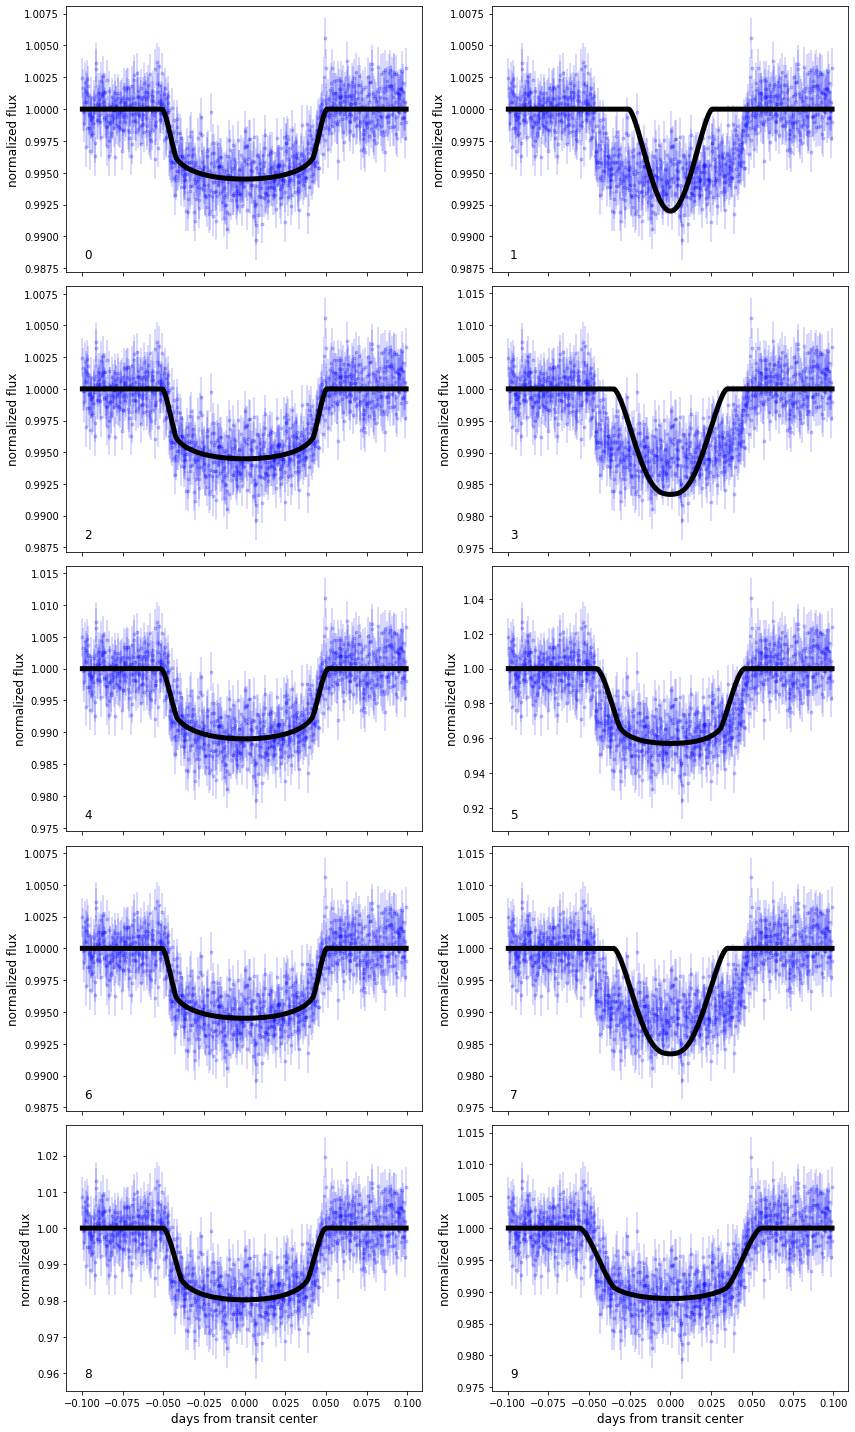

In [7]:
target.plot_fits(time=time, flux_0=flux, flux_err_0=flux_err, P_orb=P_orb)

## Example #2

Next, let's repeat this calculation while folding in follow up data. We'll see how including a contrast curve of the target star changes these results and further constrains the FPP. Note that the contrast curve file should be a csv with no headers, where the first column is the angular separation (in arcseconds) and the second column is the $\Delta$ mag.

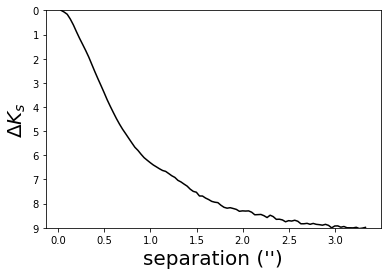

In [8]:
contrastcurve_file = "TOI465_01_contrastcurve.csv"
cc = pd.read_csv(contrastcurve_file, header=None)
sep, dmag = cc[0].values, cc[1].values

plt.plot(sep, dmag, 'k-');
plt.ylim(9,0);
plt.ylabel("$\\Delta K_s$", fontsize=20);
plt.xlabel("separation ('')", fontsize=20);

In [9]:
target.calc_probs(time=time, flux_0=flux, flux_err_0=flux_err, P_orb=P_orb, contrast_curve_file=contrastcurve_file)

TRILEGAL form submitted.
Calculating TTP and TEB scenario probabilities for 270380593.
Calculating PTP, PEB, STP, and SEB scenario probabilities for 270380593.
Calculating DTP, DEB, BTP, and BEB scenario probabilities for 270380593.


In [10]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
df_results

FPP = 0.0195


,ID,scenario,ms,rs,Teff,lum,fluxratio,Delta_mag,inc,rp,lnL,lnprior,prob
0,270380593,TTP,0.811000,0.847380,4936.0,0.384018,0.000000,-inf,87.411926,6.472223,-0.162726,-9.604098,6.787382e-01
1,270380593,TEB,0.800615,0.825049,4897.0,0.352674,0.000000,-inf,83.784083,0.467338,-1063.245495,-10.781879,0.000000e+00
2,270380593,PTP,0.815420,0.839945,4952.0,0.382224,0.003965,6.0,87.520117,6.414174,-0.001817,-10.581308,3.000457e-01
3,270380593,PEB,0.700023,0.730045,4466.0,0.191015,0.500000,0.0,86.252571,0.100000,-737.821671,-13.854812,0.000000e+00
4,270380593,STP,0.700773,0.730779,4470.0,0.192086,0.500000,0.0,88.600723,7.724200,-1.394882,-11.922796,1.947988e-02
5,270380593,SEB,0.555650,0.559729,3744.0,0.051348,0.136807,2.0,90.000000,0.108222,-156.944383,-12.800604,2.259796e-70
6,270380593,DTP,0.816234,0.840779,4955.0,0.383912,0.000631,8.0,87.513396,6.410605,0.000000,-15.735309,1.736289e-03
7,270380593,DEB,0.700023,0.730045,4466.0,0.191015,0.500000,0.0,86.252571,0.100000,-737.821671,-25.861476,0.000000e+00
8,270380593,BTP,0.630000,0.640000,4000.0,0.110000,0.284747,1.0,89.999911,8.995169,-14.753490,-20.518591,5.687348e-12
9,270380593,BEB,1.106218,1.226674,5999.0,1.755771,0.500000,0.0,85.251796,0.128142,-13.797105,-24.570601,2.573340e-13


Folding in the follow up reduced the FPP! This is because the most likely FP scenario (STP), which involves an unresolved companion with $\Delta$ mag = 0, can be ruled out beyond ~0.1 arcseconds.

## Example #3

Lastly, let's apply the tool to TOI 411.02 (aka TIC 100990000.02), which was observed with a 2 minute cadence in sectors 3 and 4.

In [11]:
ID = 100990000
sectors = np.array([3,4])
target = tr.target(ID=ID, sectors=sectors)

Sector 3


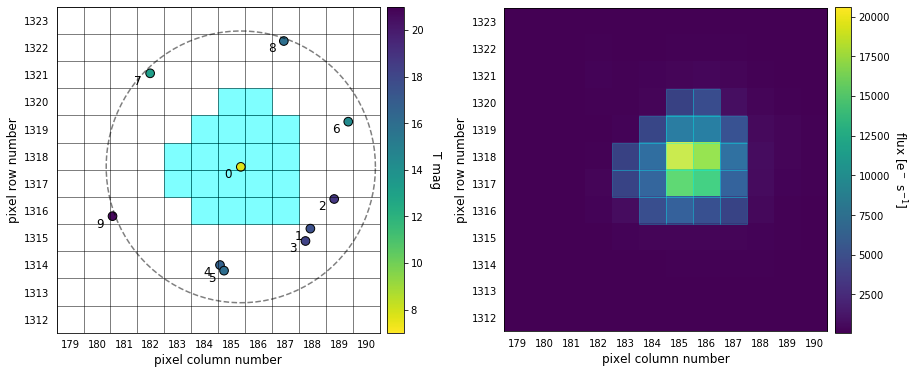

Sector 4


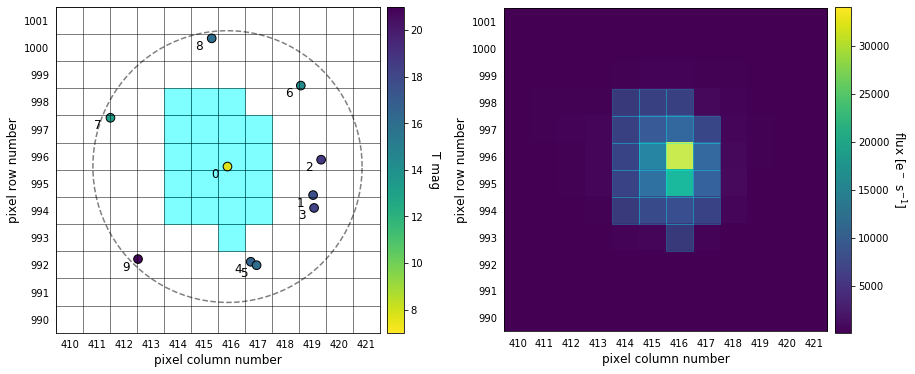

,ID,Tmag,ra,dec,mass,rad,Teff,logg,lum,plx,Vmag,Kmag
0,100990000,7.7570,54.819841,-42.762551,1.170000,1.116720,6161.0,4.41036,1.618794,15.899900,8.2700,6.981
1,100990001,17.5993,54.793531,-42.764160,NaN,NaN,6245.0,NaN,NaN,0.492555,18.0690,15.646
2,651027929,18.7320,54.795230,-42.771759,0.660000,0.537365,4205.0,4.79707,0.081339,-0.107290,19.9746,NaN
3,100989999,18.1747,54.791855,-42.761727,NaN,NaN,NaN,NaN,NaN,NaN,20.1045,16.308
4,100989997,16.6482,54.803113,-42.745878,0.501413,0.503408,3449.0,4.73442,0.032308,NaN,19.0069,14.295
5,100989996,16.0327,54.801156,-42.745691,1.070000,1.198800,5910.0,4.30996,1.579563,0.298758,16.2740,14.928
6,100990003,14.3572,54.808848,-42.784554,NaN,3.494880,5040.0,NaN,NaN,0.319435,15.1450,12.922
7,100992258,13.2329,54.856880,-42.762261,NaN,7.990850,4760.0,NaN,NaN,0.260391,14.0970,11.618
8,100990004,15.9458,54.838172,-42.786316,0.660000,0.596048,4218.0,4.70705,0.101317,1.477730,17.1802,13.960
9,651027983,20.7092,54.833929,-42.736933,NaN,NaN,NaN,NaN,NaN,NaN,21.0279,NaN


In [12]:
ap_s3 = np.array([                            [185, 1320], [186, 1320],
                                 [184, 1319], [185, 1319], [186, 1319], [187, 1319],
                    [183, 1318], [184, 1318], [185, 1318], [186, 1318], [187, 1318],
                    [183, 1317], [184, 1317], [185, 1317], [186, 1317], [187, 1317],
                                 [184, 1316], [185, 1316], [186, 1316], [187, 1316]])

ap_s4 = np.array([  [414, 998], [415, 998], [416, 998],
                    [414, 997], [415, 997], [416, 997], [417, 997],
                    [414, 996], [415, 996], [416, 996], [417, 996],
                    [414, 995], [415, 995], [416, 995], [417, 995],
                    [414, 994], [415, 994], [416, 994], [417, 994],
                                            [416, 993]])

apertures = np.array([ap_s3, ap_s4])

for i,(sector,aperture) in enumerate(zip(sectors,apertures)):
    print("Sector", sector)
    target.plot_field(sector=sector, ap_pixels=aperture)

target.stars

In [13]:
target.calc_depths(tdepth=0.000166, all_ap_pixels=apertures)
target.stars

,ID,Tmag,ra,dec,mass,rad,Teff,logg,lum,plx,Vmag,Kmag,fluxratio,tdepth
0,100990000,7.7570,54.819841,-42.762551,1.170000,1.116720,6161.0,4.41036,1.618794,15.899900,8.2700,6.981,1.0,0.000166
1,100990001,17.5993,54.793531,-42.764160,NaN,NaN,6245.0,NaN,NaN,0.492555,18.0690,15.646,0.0,0.000000
2,651027929,18.7320,54.795230,-42.771759,0.660000,0.537365,4205.0,4.79707,0.081339,-0.107290,19.9746,NaN,0.0,0.000000
3,100989999,18.1747,54.791855,-42.761727,NaN,NaN,NaN,NaN,NaN,NaN,20.1045,16.308,0.0,0.000000
4,100989997,16.6482,54.803113,-42.745878,0.501413,0.503408,3449.0,4.73442,0.032308,NaN,19.0069,14.295,0.0,0.000000
5,100989996,16.0327,54.801156,-42.745691,1.070000,1.198800,5910.0,4.30996,1.579563,0.298758,16.2740,14.928,0.0,0.000000
6,100990003,14.3572,54.808848,-42.784554,NaN,3.494880,5040.0,NaN,NaN,0.319435,15.1450,12.922,0.0,0.000000
7,100992258,13.2329,54.856880,-42.762261,NaN,7.990850,4760.0,NaN,NaN,0.260391,14.0970,11.618,0.0,0.000000
8,100990004,15.9458,54.838172,-42.786316,0.660000,0.596048,4218.0,4.70705,0.101317,1.477730,17.1802,13.960,0.0,0.000000
9,651027983,20.7092,54.833929,-42.736933,NaN,NaN,NaN,NaN,NaN,NaN,21.0279,NaN,0.0,0.000000


In [14]:
lc = pd.read_csv("TOI411_02_lightcurve.csv", header=None)
time, flux, flux_err = lc[0].values, lc[1].values, lc[2].values
P_orb = 4.040051

target.calc_probs(time=time, flux_0=flux, flux_err_0=flux_err, P_orb=P_orb)

TRILEGAL form submitted.
Calculating TTP and TEB scenario probabilities for 100990000.
Calculating PTP, PEB, STP, and SEB scenario probabilities for 100990000.
Calculating DTP, DEB, BTP, and BEB scenario probabilities for 100990000.


In [15]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
df_results

FPP = 0.011


,ID,scenario,ms,rs,Teff,lum,fluxratio,Delta_mag,inc,rp,lnL,lnprior,prob
0,100990000,TTP,1.170000,1.116720,6161.0,1.618794,0.000000,-inf,89.999987,1.595751,-3.538730,-6.751330,5.207455e-02
1,100990000,TEB,1.085343,1.200441,5941.0,1.617386,0.000000,-inf,83.514760,0.100000,-142.550982,-11.351786,2.220338e-64
2,100990000,PTP,1.071076,1.181810,5898.0,1.522679,0.059351,3.0,87.989618,1.747335,0.000000,-7.420620,9.179263e-01
3,100990000,PEB,0.951584,1.008317,5450.0,0.808116,0.500000,0.0,84.302993,0.100000,-140.432639,-12.494010,5.893074e-64
4,100990000,STP,0.951847,1.008696,5451.0,0.809317,0.500000,0.0,89.999968,2.036618,-6.942152,-7.476621,8.385873e-04
5,100990000,SEB,0.500795,0.510931,3637.0,0.038661,0.024503,4.0,86.649995,0.100000,-129.642546,-13.246194,1.348188e-59
6,100990000,DTP,1.071076,1.181810,5898.0,1.522679,0.059351,3.0,87.989618,1.747335,0.000000,-11.300114,1.896552e-02
7,100990000,DEB,0.951584,1.008317,5450.0,0.808116,0.500000,0.0,84.302993,0.100000,-140.432639,-16.348843,1.247985e-65
8,100990000,BTP,1.106593,1.227137,6000.0,1.758267,0.500000,0.0,87.557532,2.494551,-0.286081,-11.638435,1.015759e-02
9,100990000,BEB,1.106593,1.227137,6000.0,1.758267,0.024503,4.0,88.254494,0.102640,-1.535789,-15.990914,3.747930e-05


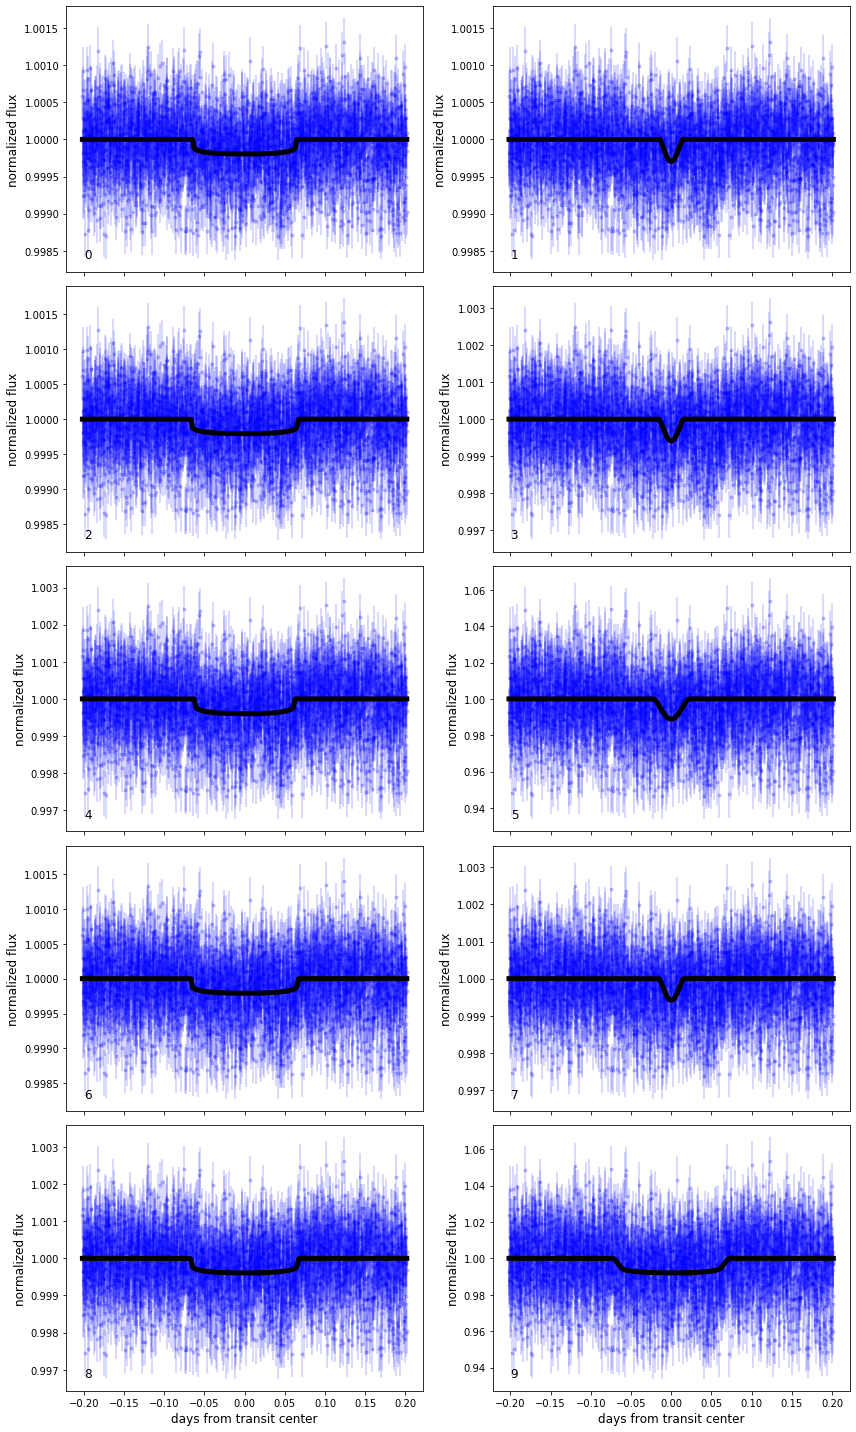

In [16]:
target.plot_fits(time=time, flux_0=flux, flux_err_0=flux_err, P_orb=P_orb)